In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [37]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [38]:
class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array is None:
      array = [random.choice([0, 1]) for i in range(length)]
    self.array = array
    self.length = length


  def decode(self, lower_bound, upper_bound, aoi):
      decoded = max_bin = '0b'
      for i in range(upper_bound - lower_bound + 1):
        decoded += str(self.array[lower_bound+i])
        max_bin += '1'
      return min_max_norm(int(decoded.replace('.', ''), 2), 0, int(max_bin.replace('.', ''), 2), aoi[0], aoi[1])


  def mutation(self, probability):
    if random.random() < probability:
      index = random.randint(0, self.length-1)
      self.array[index] = 1 - self.array[index] #bitwise NOT

  def crossover(self, other):
    index = random.randint(0, self.length-1)
    output_array_1 = np.concatenate((self.array[0:index], other.array[index:]), axis=0)
    output_array_2 = np.concatenate((other.array[0:index], self.array[index:]), axis=0)
    return [Chromosome(self.length, output_array_1), Chromosome(self.length, output_array_2)]

  def desc_chromosome(self, args_num, bits_per_arg, aoi):
    variables_str = ''
    num = 1
    for m in range(args_num):
      decoded = self.decode(m*bits_per_arg, (m+1)*bits_per_arg-1, aoi)
      variables_str += f'x{num}: {decoded:.5f} '
      num += 1
    return variables_str

In [39]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_length = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    population = []
    for i in range(population_size):
      population.append(Chromosome(self.chromosome_length))
    self.population = population

  def eval_objective_func(self, chromosome):
    points = []
    for m in range(self.obj_func_num_args):
        points.append(chromosome.decode(0+m*self.bits_per_arg, (m+1)*self.bits_per_arg-1, self.aoi))
    return self.objective_function(*points)

  def tournament_selection(self):
    candidates = random.sample(self.population, self.tournament_size)
    return min(candidates, key=lambda chromosome: self.eval_objective_func(chromosome))


  def reproduce(self, parents):
    if random.random() < self.crossover_probability:
      return parents[0].crossover(parents[1])
    else:
      return parents


  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)

  def run(self):
    best_individuals = []
    for i in range(self.num_steps):
      new_population = []
      for j in range(int(len(self.population)/2)):
        parents = random.sample(self.population, 2)
        reproduced = self.reproduce(parents)          #either crossover or parents go through
        new_population.append(reproduced[0])
        new_population.append(reproduced[1])

      for j in range(len(self.population)):
        new_population[j].mutation(self.mutation_probability)
      self.population = new_population

      tournament_output = []
      for j in range(len(self.population)):
        tournament_output.append(self.tournament_selection())
      self.population = tournament_output

      best_individuals.append(min(new_population, key=lambda chromosome: self.eval_objective_func(chromosome)))
      variables_str = best_individuals[i].desc_chromosome(self.obj_func_num_args, self.bits_per_arg, self.aoi)
      print(variables_str + f'Value: {self.eval_objective_func(best_individuals[i]):.5f}')

    trace_init = []
    for m in range(self.obj_func_num_args):
      trace_init.append(best_individuals[0].decode(m*self.bits_per_arg, (m+1)*self.bits_per_arg-1, self.aoi))
    trace = np.array(trace_init)
    for n in range(len(best_individuals)-1): #Cannot concatenate another arrays with n dimensions using vstack without at least single array of that dimension
      points = []
      for m in range(self.obj_func_num_args):
        points.append(best_individuals[n+1].decode(m*self.bits_per_arg, (m+1)*self.bits_per_arg-1, self.aoi))
      trace = np.vstack([trace, points])

    self.plot_func(trace)
    plt.show()



aoi: [-3.5, 3.5]
x1: 0.42549 x2: -0.01373 Value: 0.65880
x1: 0.09608 x2: 0.17843 Value: 0.53832
x1: 0.09608 x2: 0.15098 Value: 0.52936
x1: 0.09608 x2: 0.15098 Value: 0.52936
x1: 0.09608 x2: 0.15098 Value: 0.52936
x1: 0.09608 x2: 0.15098 Value: 0.52936
x1: 0.09608 x2: -0.01373 Value: 0.50510
x1: 0.09608 x2: -0.01373 Value: 0.50510
x1: 0.09608 x2: -0.01373 Value: 0.50510
x1: 0.04118 x2: 0.01373 Value: 0.49843
x1: 0.06863 x2: -0.01373 Value: 0.50082
x1: 0.04118 x2: 0.06863 Value: 0.50362
x1: 0.04118 x2: -0.01373 Value: 0.49802
x1: 0.04118 x2: -0.01373 Value: 0.49802
x1: 0.04118 x2: -0.01373 Value: 0.49802
x1: 0.04118 x2: -0.01373 Value: 0.49802
x1: 0.04118 x2: -0.01373 Value: 0.49802
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value

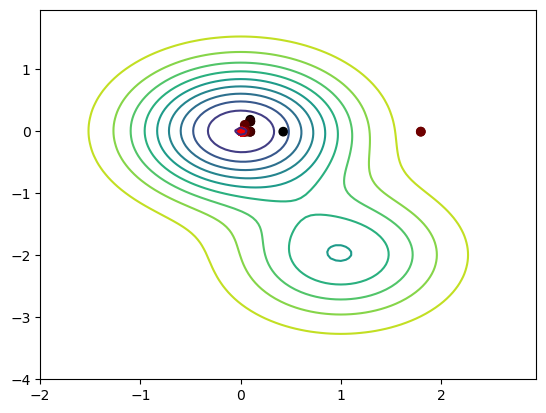

aoi: [-8, 8]
x1: 0.78431 x2: -0.21961 Value: 0.96484
x1: 0.78431 x2: -0.21961 Value: 0.96484
x1: 1.03529 x2: -2.03922 Value: 0.99604
x1: 0.78431 x2: -0.21961 Value: 0.96484
x1: 0.28235 x2: -0.47059 Value: 0.73125
x1: 0.28235 x2: -0.59608 Value: 0.81114
x1: 0.34510 x2: -0.47059 Value: 0.75722
x1: 0.47059 x2: -0.47059 Value: 0.82141
x1: 0.03137 x2: -0.40784 Value: 0.63856
x1: 0.03137 x2: -0.40784 Value: 0.63856
x1: 0.03137 x2: -0.40784 Value: 0.63856
x1: 0.03137 x2: -0.40784 Value: 0.63856
x1: 0.03137 x2: -0.09412 Value: 0.50462
x1: 0.03137 x2: -0.09412 Value: 0.50462
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.09412 Value: 0.50462
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.03137 Value: 0.49791
x1: 0.03137 x2: -0.03137 Va

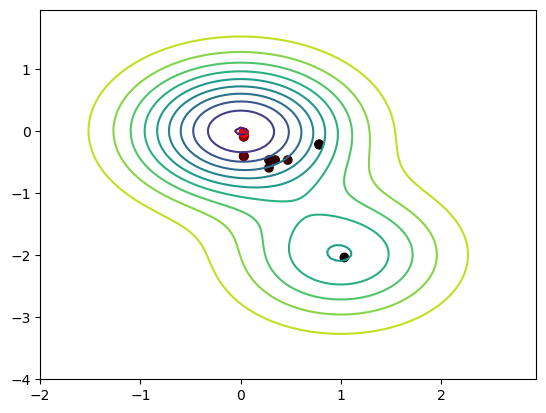

aoi: [-15, 15]
x1: 0.05882 x2: -0.64706 Value: 0.81130
x1: 0.05882 x2: -0.64706 Value: 0.81130
x1: 0.05882 x2: -0.52941 Value: 0.72332
x1: 0.05882 x2: -0.64706 Value: 0.81130
x1: 0.05882 x2: -0.64706 Value: 0.81130
x1: 0.05882 x2: -0.64706 Value: 0.81130
x1: 0.05882 x2: -0.29412 Value: 0.57481
x1: 0.29412 x2: -0.29412 Value: 0.64232
x1: 0.29412 x2: -0.29412 Value: 0.64232
x1: 0.29412 x2: -0.05882 Value: 0.57902
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.29412 Value: 0.57481
x1: 0.05882 x2: -0.29412 Value: 0.57481
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 Value: 0.50213
x1: 0.05882 x2: -0.05882 

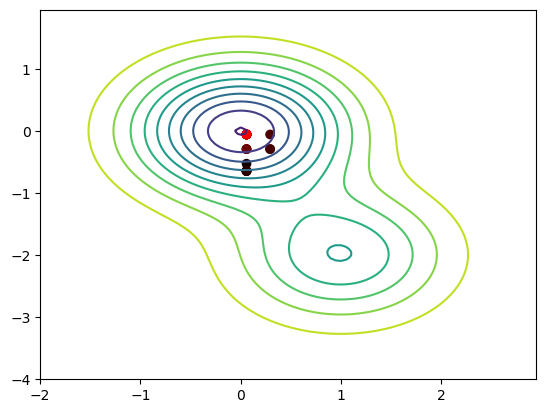

aoi: [-30, 30]
x1: 1.76471 x2: -3.64706 Value: 1.48151
x1: 1.76471 x2: -3.64706 Value: 1.48151
x1: 1.76471 x2: -1.05882 Value: 1.37063
x1: 0.82353 x2: -1.05882 Value: 1.13472
x1: 0.82353 x2: -1.29412 Value: 1.11044
x1: 0.82353 x2: -2.23529 Value: 1.03800
x1: 0.82353 x2: -2.23529 Value: 1.03800
x1: 0.82353 x2: -2.00000 Value: 1.00604
x1: 0.82353 x2: -2.00000 Value: 1.00604
x1: 0.82353 x2: -2.00000 Value: 1.00604
x1: 0.82353 x2: -2.00000 Value: 1.00604
x1: 0.82353 x2: -2.00000 Value: 1.00604
x1: 0.82353 x2: -2.00000 Value: 1.00604
x1: 0.82353 x2: -2.00000 Value: 1.00604
x1: 0.58824 x2: -0.58824 Value: 0.94194
x1: 0.82353 x2: -0.11765 Value: 0.98543
x1: 0.82353 x2: -0.11765 Value: 0.98543
x1: 0.35294 x2: -0.11765 Value: 0.61974
x1: 0.35294 x2: -0.11765 Value: 0.61974
x1: 0.35294 x2: -0.11765 Value: 0.61974
x1: 0.35294 x2: -0.11765 Value: 0.61974
x1: 0.35294 x2: -0.11765 Value: 0.61974
x1: 0.35294 x2: -0.11765 Value: 0.61974
x1: 0.35294 x2: -0.11765 Value: 0.61974
x1: 0.35294 x2: -0.11765 

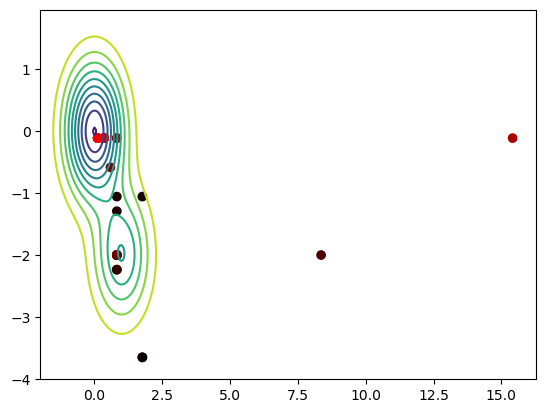

population: 10
x1: 1.68824 x2: 1.24902 Value: 1.48784
x1: 0.23333 x2: 0.12353 Value: 0.56427
x1: 0.23333 x2: 0.12353 Value: 0.56427
x1: 0.23333 x2: 0.12353 Value: 0.56427
x1: 0.23333 x2: 0.12353 Value: 0.56427
x1: 0.23333 x2: 0.04118 Value: 0.55029
x1: 0.23333 x2: 0.04118 Value: 0.55029
x1: 0.23333 x2: 0.04118 Value: 0.55029
x1: 0.23333 x2: 0.04118 Value: 0.55029
x1: 0.23333 x2: 0.04118 Value: 0.55029
x1: 0.23333 x2: 0.04118 Value: 0.55029
x1: 0.01373 x2: 0.04118 Value: 0.49895
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.23333 x2: 0.01373 Value: 0.54835
x1: 0.2333

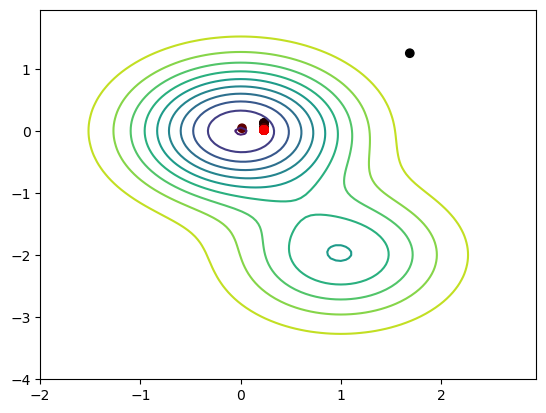

population: 100
x1: 0.45294 x2: -0.50784 Value: 0.83065
x1: 0.45294 x2: -0.48039 Value: 0.81652
x1: 0.59020 x2: 0.34314 Value: 0.87080
x1: -0.06863 x2: 0.56275 Value: 0.77464
x1: -0.26078 x2: 0.48039 Value: 0.75806
x1: -0.06863 x2: 0.50784 Value: 0.73067
x1: 0.15098 x2: 0.45294 Value: 0.70324
x1: 0.15098 x2: 0.45294 Value: 0.70324
x1: -0.26078 x2: 0.12353 Value: 0.57877
x1: 0.09608 x2: 0.45294 Value: 0.69243
x1: 0.15098 x2: 0.04118 Value: 0.52042
x1: 0.15098 x2: 0.04118 Value: 0.52042
x1: 0.15098 x2: 0.01373 Value: 0.51851
x1: 0.12353 x2: 0.04118 Value: 0.51322
x1: 0.04118 x2: 0.04118 Value: 0.50029
x1: 0.04118 x2: 0.01373 Value: 0.49843
x1: 0.12353 x2: 0.01373 Value: 0.51131
x1: 0.12353 x2: 0.01373 Value: 0.51131
x1: 0.12353 x2: 0.01373 Value: 0.51131
x1: 0.12353 x2: 0.01373 Value: 0.51131
x1: 0.12353 x2: 0.01373 Value: 0.51131
x1: 0.12353 x2: 0.01373 Value: 0.51131
x1: 0.01373 x2: 0.01373 Value: 0.49710
x1: 0.01373 x2: 0.01373 Value: 0.49710
x1: 0.01373 x2: 0.01373 Value: 0.49710
x1:

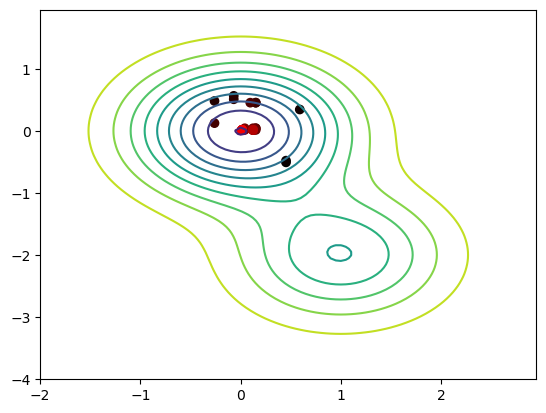

population: 1000
x1: 0.01373 x2: 0.01373 Value: 0.49710
x1: 0.06863 x2: -0.01373 Value: 0.50082
x1: 0.06863 x2: -0.01373 Value: 0.50082
x1: 0.06863 x2: -0.01373 Value: 0.50082
x1: -0.01373 x2: -0.04118 Value: 0.49802
x1: -0.01373 x2: -0.01373 Value: 0.49692
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.01373 Value: 0.49672
x1: 0.01373 x2: -0.013

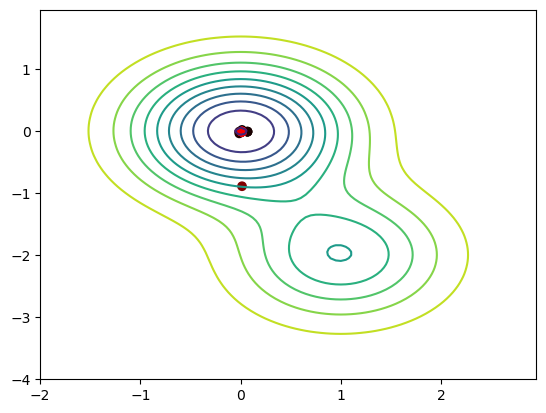

In [40]:
def objective_function(x, y):
    return 1.5 - np.exp(-x**2 - y**2) - 0.5 * np.exp(-(x - 1)**2 - (y + 2)**2)

aois = [[-3.5, 3.5], [-8, 8], [-15, 15], [-30, 30]]
for aoi in aois:
    print(f'aoi: {aoi}')
    ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function, aoi=aoi, population_size=100)
    ga.run()


populations = [10, 100, 1000]
for population in populations:
    print(f'population: {population}')
    ga = GeneticAlgorithm(chromosome_length=16, obj_func_num_args=2, objective_function=objective_function, aoi=aois[0], population_size=population)
    ga.run()

PL
Wnioski
Zaimplementowany powyżej algorytm genetyczny od razu daje się poznać jako trudniejszy "w obsłudze" niż chociażby algorytm gradientu prostego. Przede wszystkim występuje tu wiele parametrów, które należy prawidłowo ustawić. Literatura wskazuje na konieczność wybrania dostatecznie dużej populacji, znacznie większej od wymiarowości problemu, co potwierdzają symulacje. Występują tu również inne parametry, które nie były przedmiotem badań, lecz tu również z pomocą przychodzi literatura sugerująca chociażby niskie prawdopodobieństwo mutacji.
Największym problemem jest jednak dobranie przedziału aoi, który jest wykorzystywany do oszacowania gdzie występuje minimum. Jest to problem analogiczny do wyboru punktu startowego dla algorytmu gradientu prostego, lecz nie tak krytyczny jak w przypadku tego drugiego. W tym przypadku jest szansa na nieutknięcie w minimum lokalnym i swoiste wyjście z niego, lecz nie jest to deterministyczne. W ogólności znając "region" ekstremum globalnego algorytm dość dobrze je znajduje, jeśli mamy prawidłowo dobrane inne parametry, lecz niezbyt dobrze radzi sobie w większym zakresie.

ENG
Conclusions:
The genetic algorithm implemented above is immediately recognizable as more challenging to handle than, for example, the simple gradient descent algorithm. First and foremost, it involves many parameters that need to be set correctly. The literature suggests the need to select a sufficiently large population, significantly larger than the dimensionality of the problem, which is confirmed by simulations. There are also other parameters that were not the subject of this study, but here too, the literature suggests, for instance, a low mutation probability.

However, the biggest challenge is choosing the region of interest (AOI) used to estimate where the minimum occurs. This is a problem analogous to choosing the starting point for a gradient descent algorithm but not as critical as in the case of the latter. In this case, there is a chance of not getting stuck in a local minimum and finding a specific way out, but it is not deterministic. In general, with knowledge of the 'region' of the global extremum, the algorithm performs quite well in finding it if other parameters are properly tuned, but it doesn't perform well in a wider range.